In [153]:
import pandas as pd
import numpy as np
# import researchpy as rp
from scipy import stats

import matplotlib.pyplot as plt
import pydotplus
from matplotlib import rcParams
import seaborn as sb

from collections import Counter

In [1]:
%run data_cleaning.ipynb

(4617, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617 entries, 0 to 4616
Data columns (total 21 columns):
State                   4617 non-null object
Account Length          4617 non-null object
Area Code               4617 non-null object
Phone                   4617 non-null object
International Plan      4617 non-null object
VMail Plan              4617 non-null object
VMail Message           4617 non-null object
Day Mins                4617 non-null object
Day Calls               4617 non-null object
Day Charge              4617 non-null object
Eve Mins                4617 non-null object
Eve Calls               4617 non-null object
Eve Charge              4617 non-null object
Night Mins              4617 non-null object
Night Calls             4617 non-null object
Nights Charge           4617 non-null object
International Mins      4617 non-null object
International Calls     4617 non-null object
International Charge    4617 non-null object
CustServ Calls          461

In [50]:
def get_column_info(data):
    print(data.columns)
    print(len(data.columns))
    return data.columns, len(data.columns)
    
def filter_by_type(data, type1):
    print(type1)
    if isinstance(type1, list):
        filter_ = eval(" | ".join([f"(data.dtypes == '{i}')" for i in type1]))
        type1_columns_df = data.loc[:, filter_]
        get_column_info(type1_columns_df)
    elif isinstance(type1, str):
        filter_ = f"(data.dtypes == '{type1}')"
        type1_columns_df = data.loc[:, filter_]
        get_column_info(type1_columns_df)
        
def get_column_info_and_types(data):
    get_column_info(data)
    filter_by_type(data, ['int32', 'int64'])
    filter_by_type(data, ['float32', 'float64'])
    
get_column_info_and_types(data_encoded)

Index(['State', 'Account Length', 'Area Code', 'Phone', 'International Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Nights Charge', 'International Mins', 'International Calls',
       'International Charge', 'CustServ Calls', 'Churn'],
      dtype='object')
21
['int32', 'int64']
Index(['State', 'Account Length', 'Area Code', 'Phone', 'International Plan',
       'VMail Plan', 'VMail Message', 'Day Calls', 'Eve Calls', 'Night Calls',
       'International Calls', 'CustServ Calls', 'Churn'],
      dtype='object')
13
['float32', 'float64']
Index(['Day Mins', 'Day Charge', 'Eve Mins', 'Eve Charge', 'Night Mins',
       'Nights Charge', 'International Mins', 'International Charge'],
      dtype='object')
8


## Manually classify the data types to Numerical(continous, discrete) and Categorical(ordinal, nominal)

In [58]:

data_type_info = {'State': 'nominal',
          'Account Length': 'discrete',
          'Area Code': 'nominal',
          'Phone': 'nominal',
          'International Plan': 'bool',
          'VMail Plan': 'bool',
          'VMail Message': 'discrete',
          'Day Mins': 'continuous',
          'Day Calls': 'discrete',
          'Day Charge': 'continuous',
           'Eve Mins': 'continuous',
          'Eve Calls': 'continuous',
          'Eve Charge': 'continuous',
          'Night Mins': 'continuous',
          'Night Calls': 'discrete',
        'Nights Charge': 'continuous',
          'International Mins': 'continuous',
          'International Calls': 'discrete',
       'International Charge': 'continuous',
          'CustServ Calls': 'discrete',
          'Churn': 'bool'}


def get_type(data_type_info, type1):
    keys = [k for k, v in data_type_info.items() if v == type1]
    if type1 in ['nominal', 'ordinal', 'bool']:
        base_type = 'categorical'
    elif type1  in ['continuous', 'discrete']:
        base_type = 'numerical'
    
    return base_type, type1, keys, len(keys)
    
for type1 in ['continuous', 'discrete', 'ordinal', 'nominal', 'bool']:
    print(get_type(data_type_info, type1))

('numerical', 'continuous', ['Day Mins', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Nights Charge', 'International Mins', 'International Charge'], 9)
('numerical', 'discrete', ['Account Length', 'VMail Message', 'Day Calls', 'Night Calls', 'International Calls', 'CustServ Calls'], 6)
('categorical', 'ordinal', [], 0)
('categorical', 'nominal', ['State', 'Area Code', 'Phone'], 3)
('categorical', 'bool', ['International Plan', 'VMail Plan', 'Churn'], 3)


# Check Multi-Collinearity - using Correlation on predictor continuous variables 

In [138]:
continous_variables = get_type(data_type_info, 'continuous')[2]

cor_continous_variables = data_encoded[continous_variables].corr(method='pearson').round(2)
# c = cor_continous_variables.unstack().sort_values(ascending=False)

def get_high_correlations(data, continous_variables, threshold):
    c = data[continous_variables].corr(method='pearson').round(2)
    d = {}
    for i in c.index:
        for j in c.columns:
            if i != j and c.loc[i, j] > threshold:
                if not d.get((j, i)): 
                    # print(c.loc[i, j], i, j)
                    d[(i, j)] = c.loc[i, j]
    return d

get_high_correlations(data_encoded, continous_variables, .8)

{('Day Mins', 'Day Charge'): 1.0,
 ('Eve Mins', 'Eve Charge'): 1.0,
 ('Night Mins', 'Nights Charge'): 1.0,
 ('International Mins', 'International Charge'): 1.0}

# Checking if each categoriable variable has a statistically signifcant association with categorical outcome variable

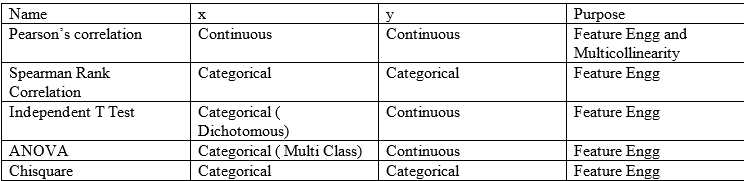




## Below sample is for just one, we have to do for every combination of categorical predictor with outcome varibales

In [146]:
def get_categorical(data_type_info):
    results = []
    for type1 in ['ordinal', 'nominal', 'bool']:
        result = get_type(data_type_info, type1)
        results.extend(result[2])
    return results

get_categorical(data_type_info)

['State', 'Area Code', 'Phone', 'International Plan', 'VMail Plan', 'Churn']

In [159]:
categorical_variables = get_categorical(data_type_info)
categorical_variables.remove('Churn')
target_variable = 'Churn'

def chi_square_test(df1, categorical_variables, target_variable):
    #Null Hypothesis: There is no association between the variables

    for column in categorical_variables:
        # print(pd.crosstab(df1[column], df1[target_variable]))
        chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(df1[column], df1[target_variable]))

        #print("Chi     :",chi2)
        #print("P-value :",p)
        #print("dof     :",dof)
        #print("expected:",expected)
        if p < 0.05:
            print(column, target_variable, p)

print(categorical_variables)
chi_square_test(data_encoded, categorical_variables, target_variable)

['State', 'Area Code', 'Phone', 'International Plan', 'VMail Plan']
State Churn 0.0003716382614441669
International Plan Churn 5.1469217589105615e-68
VMail Plan Churn 1.0310215433169948e-13


In [160]:
# Repeat the above for every combination and you will get the result:
#p-value:0.0 < 0.05. Therefore c_workclass is IMPORTANT for Prediction
#p-value:0.0 < 0.05. Therefore q_fnlwgt is IMPORTANT for Prediction
#p-value:0.0 < 0.05. Therefore c_education is IMPORTANT for Prediction
#p-value:0.0 < 0.05. Therefore c_marital_status is IMPORTANT for Prediction
#p-value:0.0 < 0.05. Therefore c_occupation is IMPORTANT for Prediction
#p-value:0.0 < 0.05. Therefore c_relationship is IMPORTANT for Prediction
#p-value:0.0 < 0.05. Therefore c_race is IMPORTANT for Prediction
#p-value:0.0 < 0.05. Therefore c_sex is IMPORTANT for Prediction
#p-value:0.0 < 0.05. Therefore c_native_country is IMPORTANT for Prediction